In [7]:
import numpy as np

In [8]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [230]:
N = 1001 # 1001
l = 10
xvec, dx = np.linspace(-l, l, N, retstep=True)
print(dx)
print(dx - (xvec[1] - xvec[0]))

0.02
4.2674197509029455e-16


In [273]:
# effective grid
# grid scaling
# this determines the density of our Gaussians
# which relates the number of bases we are using
# a Gaussian will cented every gs*dx step
# gs = 10

# this is the grid of center positions for our
# Gaussian basis
# xx = np.arange((N-1)//gs + 1) * dx * gs - l

# gx = dx*gs

# Let's redo the above code so that we can directly
# set the number of bases we use
Ng = 101 # 101
xx, gx = np.linspace(-l, l, Ng, retstep=True)

# where gx = gs*dx
gs = gx/dx

print(gs)
print(xx.shape)
print(xx)

10.0
(101,)
[-10.   -9.8  -9.6  -9.4  -9.2  -9.   -8.8  -8.6  -8.4  -8.2  -8.   -7.8
  -7.6  -7.4  -7.2  -7.   -6.8  -6.6  -6.4  -6.2  -6.   -5.8  -5.6  -5.4
  -5.2  -5.   -4.8  -4.6  -4.4  -4.2  -4.   -3.8  -3.6  -3.4  -3.2  -3.
  -2.8  -2.6  -2.4  -2.2  -2.   -1.8  -1.6  -1.4  -1.2  -1.   -0.8  -0.6
  -0.4  -0.2   0.    0.2   0.4   0.6   0.8   1.    1.2   1.4   1.6   1.8
   2.    2.2   2.4   2.6   2.8   3.    3.2   3.4   3.6   3.8   4.    4.2
   4.4   4.6   4.8   5.    5.2   5.4   5.6   5.8   6.    6.2   6.4   6.6
   6.8   7.    7.2   7.4   7.6   7.8   8.    8.2   8.4   8.6   8.8   9.
   9.2   9.4   9.6   9.8  10. ]


0.14426950408889638


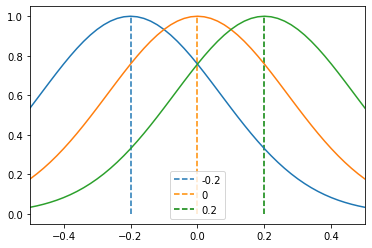

In [309]:
# for plotting
def gauss(x, j):
    return np.exp(-(x - j*gx)**2 / sigma)

# first attempt at finding the optimal amount of overlap
# by hand
# sigma = dx*2

# this should insure that not matter the number of bases
# we will have about the same overlap
overlap = 20 # 6
sigma = overlap * gx**2 / (8 * np.log(2)) 
print(sigma)



plt.plot(xvec, gauss(xvec,-1))
plt.vlines(-1*gx, ymin=0, ymax=1, label=-1*gx, linestyles='dashed')
plt.plot(xvec, gauss(xvec,0))
plt.vlines(0, ymin=0, ymax=1, label=0, color='darkorange', linestyles='dashed')
plt.plot(xvec, gauss(xvec,1))
plt.vlines(gx, ymin=0, ymax=1, label=gx, color='green', linestyles='dashed')
plt.xlim([-0.5,0.5])
plt.legend()
plt.show()

In [310]:
# We want a matrix which is constructed by evaluating
# each of the shifted Gaussians at all of the spacial
# grid points
# Here we have one Gaussian centered at each spacial
# grid point
# gmat = np.exp(-(np.expand_dims(xx,0) - np.expand_dims(xx,1))**2 / sigma)
# Because of broadcasting we only need to expand one of the arrays
# so that the dimension is (#, 1)
gmat = np.exp(-(xx - np.expand_dims(xx,1))**2 / sigma)
print(gmat.shape)
np.linalg.cond(gmat)

(101, 101)


3605.376111737353

In [311]:
gmatplot = np.exp(-(np.expand_dims(xx,0) - np.expand_dims(xvec,1))**2 / sigma)
print(gmatplot.shape)

(1001, 101)


In [312]:
def myfunc(x):
    # out = (x < -3)*(x+3)**3/350 + ((x >= -3) & (x < 6))*(np.exp(-x - 3) - 1) + (x >= 6)*(np.exp(-9) - 1 + (x-6)**2/14)
    out = 2*np.cos(x) + np.sin(5*x)
    return out

In [313]:
coefs = np.linalg.inv(gmat) @ myfunc(xx)

In [314]:
coefs

array([-3.38392012e+00,  4.08596567e+00, -3.95472390e+00,  2.70757794e+00,
       -4.05831634e+00,  1.03179534e+00, -2.23438154e+00,  1.51437212e+00,
       -6.60414798e-01,  6.77260262e-01, -1.22016269e+00, -2.28023722e-01,
       -3.99060244e-01,  9.96613156e-01,  9.06972496e-01,  9.24570429e-01,
        3.70209778e-02, -6.22170550e-02,  1.44267931e-01,  9.57999463e-01,
        1.27789472e+00,  1.05900158e+00,  2.58363914e-01, -2.93061008e-01,
       -2.81647589e-01,  2.80775798e-01,  7.09754552e-01,  5.55554282e-01,
       -1.86824582e-01, -9.11326325e-01, -1.07312494e+00, -5.95174420e-01,
       -4.03303982e-03,  1.09144261e-01, -4.04956796e-01, -1.08519458e+00,
       -1.30586467e+00, -8.35020118e-01, -6.17350586e-02,  3.69602410e-01,
        1.41702129e-01, -4.41480094e-01, -7.42200597e-01, -3.76105113e-01,
        4.27665738e-01,  1.03470408e+00,  9.83045706e-01,  4.05115542e-01,
       -9.82000627e-02, -1.21854323e-02,  6.15965691e-01,  1.21958955e+00,
        1.23288057e+00,  

0.08760043579379206


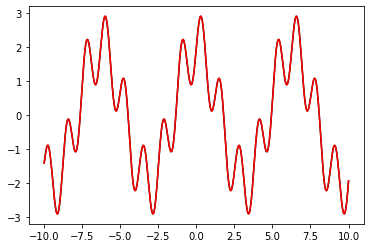

In [315]:
myfuncapprox = gmatplot @ coefs

print(np.linalg.norm(myfunc(xvec) - myfuncapprox)) # 0.18633125114381555 for Ng=101

plt.plot(xvec, myfunc(xvec), color='black')

plt.plot(xvec, myfuncapprox, color='red')
plt.show()

i=10 value: 0.23903327389085874
min value: 0.001688902844684959
last value: 0.002065269260662221
index of min: 45
total length: 49


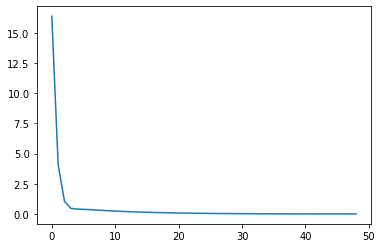

In [339]:
norm = []
for i in range(1, 50):
    overlap = i
    sigma = overlap * gx**2 / (8 * np.log(2)) 
    gmat = np.exp(-(xx - np.expand_dims(xx,1))**2 / sigma)
    if np.linalg.cond(gmat) > 1e10:
        break
    else:
        gmatplot = np.exp(-(np.expand_dims(xx,0) - np.expand_dims(xvec,1))**2 / sigma)
        coefs = np.linalg.inv(gmat) @ myfunc(xx)
        myfuncapprox = gmatplot @ coefs
        norm.append(np.linalg.norm(myfunc(xvec) - myfuncapprox))

print('i=10 value:', norm[10])
print('min value:', np.amin(norm))
print('last value:', norm[-1])
print('index of min:', np.argmin(norm))
print('total length:', len(norm))
plt.plot(norm)
plt.show()